РК№1 ИУ5-22М Колпаков М.О. Вариант-7, задача-1, набор данных-7

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
data1 = pd.read_csv('/content/drive/My Drive/Admission_Predict_Ver1.1.csv', sep=',')
print('rows: ',data1.shape[0])
print('columns: ',data1.shape[1])

rows:  500
columns:  9


In [34]:
def getColumns(dataName, data):
  print(dataName)
  df = pd.DataFrame(data = np.c_[data.columns, data1.dtypes.values], columns= ['columnName', 'columnType'])
  print(df, '\n')

getColumns(dataName= 'Graduate Admission 2', data= data1)

Graduate Admission 2
          columnName columnType
0         Serial No.      int64
1          GRE Score      int64
2        TOEFL Score      int64
3  University Rating      int64
4                SOP    float64
5               LOR     float64
6               CGPA    float64
7           Research      int64
8   Chance of Admit     float64 



In [35]:
def getColumnsWithEmptyCells(dataToPrepare, printFlag=True ): 
  percentOfMissingValues = round(dataToPrepare.isnull().sum() / len(dataToPrepare) * 100 , 2)
  percentOfMissingValues = percentOfMissingValues[percentOfMissingValues > 0]
  columnTypes = pd.Series(dataToPrepare[percentOfMissingValues.index.values].dtypes)
  if(printFlag):
    print(pd.DataFrame(data= np.c_[percentOfMissingValues, columnTypes], columns=['Missing %', 'Type'], index= [percentOfMissingValues.index.values]))
  return percentOfMissingValues.index.values

getColumnsWithEmptyCells(data1)

Empty DataFrame
Columns: [Missing %, Type]
Index: []


array([], dtype=object)

В данном датасете не содержится пропусков, поэтому нет необходимости в поиске алгоритма замены пропусков. Рассмотрим названия колонок.

In [36]:
def correctColumns(colArray: np.array):
  res = dict()
  correctedCols = dict()
  for name in colArray:
    spaces = 0
    for char in name:
      if char ==' ':
        spaces +=1
    words_count = len(name.split())
    mustBe = words_count - 1
    if mustBe != spaces:
      print(name, {'spaces': spaces, 'must_be': mustBe})
    correctedCols[name] = name.strip()
  return correctedCols

newCols = correctColumns(data1.columns)
data2 = data1.rename(newCols, axis='columns', errors='raise')

LOR  {'spaces': 1, 'must_be': 0}
Chance of Admit  {'spaces': 3, 'must_be': 2}


Не во всех названиях колонок находится коррекктное число пробелов => надо х скорректировать

1. Разведочный анализ

In [37]:
for col in data2.columns:
  print (col, 'count of unique:', len(data2[col].unique()))

Serial No. count of unique: 500
GRE Score count of unique: 49
TOEFL Score count of unique: 29
University Rating count of unique: 5
SOP count of unique: 9
LOR count of unique: 9
CGPA count of unique: 184
Research count of unique: 2
Chance of Admit count of unique: 61


Колонка Chance of Admit count of unique отображает вероятность поступления и соответственно представляет для нас наибольший интерес

Корреляционный анализ

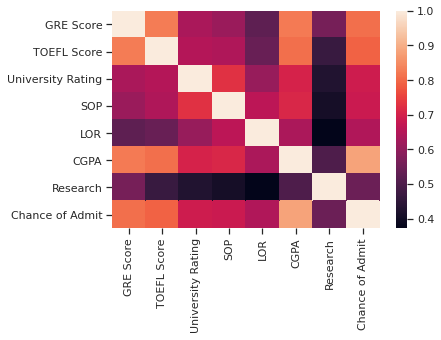

In [38]:
import seaborn as sbrn
sbrn.heatmap(data2[data2.columns[1:]].corr())

в наибольшей линейной зависимости от Chance of Admit находится CGPA, тогда как GRE Score и TOEFL Score находятся в чуть меньшей. Дальнейший анализ будем проводить, опираясь на эти переменные.

Распределения CGPA, GRE Score, TOEFL Score

In [0]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as pltl

In [40]:

fig = make_subplots(rows=1, cols=3)

fig.add_trace(go.Scatter(x=data2['Chance of Admit'], y=data2['CGPA'],  mode='markers'), 
                row=1, 
                col=1)

fig.add_trace(go.Scatter(x= data2['Chance of Admit'], y=  data2['GRE Score'],  mode='markers'), 
                row=1, 
                col=2)

fig.add_trace(go.Scatter(x=data2['Chance of Admit'], y=  data2['TOEFL Score'],  mode='markers'), 
                row=1, 
                col=3)

fig.update_xaxes(title_text="Chance of Admit", row=1, col=1)
fig.update_yaxes(title_text="CGPA", row=1, col=1)

fig.update_xaxes(title_text="Chance of Admit", row=1, col=2)
fig.update_yaxes(title_text="GRE Score", row=1, col=2)

fig.update_xaxes(title_text="Chance of Admit", row=1, col=3)
fig.update_yaxes(title_text="TOEFL Score", row=1, col=3)

# fig.update_layout(
#     autosize=True,
#     height=600
# )
fig.show()

1. Чем выше значение CGPA, тем больший шанс кандидат имеет на зачисление.но есть случаи где кандидаты с высоким значением CGPA исмеют те же шансы, что и кандидаты с более низким значением.
2. Чем выше значение GRE Score, тем больший шанс кандидат имеет на зачисление, однако есть кандидаты имеющие одинаковый GRE Score, однако разный шанс поступления, в диапазоне 300 - 330. Однако несмотря на это, наблюдается линейная зависимость.
3. Шансы поступления слабее зависят от TOFL_Score, чем от рассмотренных показателей. Многие кандидаты имеют одинаковый TOFL_Score, но шансы поступления разные. Это вырожается множеством горизонтальных групп на графике распределения.

Анализ кандидатов с наибольшим шансом на зачисление

Наибольший шанс > 0.8

In [41]:
highScoreCandidates = data2[data2['Chance of Admit'] > 0.8]
print(round(highScoreCandidates.shape[0]/data2.shape[0] *100, 2), '%')

28.4 %


Таких кандидатов 28,4% от всех кандидатов

In [42]:
highScoreCandidates['Research'].unique()

array([1, 0])

Research указывает на иследовательскй опыт. 0 - отсутствие опыта, 1 - наличие опыта

In [0]:
from plotly.offline import plot
# функция построения пайчартов для лучших и всех кандидатов
def createPieCharts(title: str,
                    columnName: str):
  fig = make_subplots(rows=1, cols=2, specs=[[{"type": "pie"}, {"type": "pie"}]],subplot_titles=['Лучшие кандидаты', 'Все кандидаты'])

  fig.add_trace(go.Pie(
      labels= highScoreCandidates[columnName], 
      values= highScoreCandidates['Chance of Admit'],
      domain=dict(x=[0, 0.5])), 
      row=1, 
      col=1)

  fig.add_trace(go.Pie(labels= data2[columnName], 
                       values= data2['Chance of Admit'],
      domain=dict(x=[0.5, 1.0])),
        row=1, 
        col=2)

  fig.update_layout(title_text= title)
  fig.show()

In [45]:
createPieCharts(title='Исследовательский опыт кандидатов', columnName='Research')

Большинство кандидатов имеют исследовательский опыт - 61,8%, а из лучших кандидатов - 94%

In [46]:
createPieCharts(title='Рейтинг университета', columnName='University Rating')

Около половины кандидатов с большими шансами на поступление: 41,1% кандидатов с университетом ранга 4, 45,5% кандидатов с университетом ранга 5. Среди этих кандидатов не наблюдается университетов с рангом 1 

Выводы

Можно выделить следующие варианты построения моделей:

Регрессионная модель определения шансов кандидата на поступление.
В качестве метода машинного обучения подойдет метод К ближайших соседей (KNeighborsRegressor из библиотеки sklearn). В качестве входных переменных можно использовать CGPA и GRE_score, так как они находятся в наибольшей линейной зависимости от Chance of Admit. Также не исключена возможность использования всех переменных в качестве входных (GRE Score, TOEFL Score, University Rating, SOP, CGPA, Research) для определения выходной - Chance of Admit при использовании регрессионного KNN.

Также в качестве наиболее оптимального метода можно рассмотреть SVR. В качестве входной переменной также стоит рассматривать CGPA ввиду ее большой линейной зависимости с Chance of Admit